In [1]:
import torch
import matplotlib.pyplot as plt
from conex import Neocortex, prioritize_behaviors, SimpleDendriteStructure, SimpleDendriteComputation, SpikeTrace, \
    NeuronAxon, SynapseInit, WeightInitializer, SimpleDendriticInput, SimpleSTDP, Fire, WeightClip, LIF, \
    WeightNormalization, ActivityBaseHomeostasis, VoltageBaseHomeostasis
from pymonntorch import NeuronGroup, NeuronDimension, SynapseGroup, EventRecorder, Recorder


from models.activity import ActivityRecorder
from models.encoders import FeedDataset, CustomPoisson, Poisson
from models.learnings import PairedSTDPLocalVar, PairedRSTDPLocalVar
from models.trace import ClearSpikeTrace
from simulate import Simulation
from utils.dataset import load_data, add_overlap

# ActivityBaseHomeostasis

## Simple STDP

In [2]:
INSTANCE_DURATION = 50
SLEEP = 15

In [3]:
dataset = load_data(directory='dataset/', resize_width=3, resize_height=3)
dataset = add_overlap(dataset, overlap_ratio=0.25, epsilon=0.0)
# Create an instance of Poisson
encoder = Poisson(time_window=INSTANCE_DURATION, ratio=0.5)
# encoder = CustomPoisson(time_window=50)
encoded_dataset = torch.stack([encoder(image) for image in dataset])

In [4]:
sim = Simulation(net=Neocortex(dt=1))
input_layer = sim.add_neuron_group(
    tag="input_layer",
    # size=NeuronDimension(depth=1, height=1, width=18),
    size=18,
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            SpikeTrace(tau_s=4),
            NeuronAxon(),
        ]
    ),
)
input_layer.add_behavior(key=261,behavior=FeedDataset(encoded_dataset=encoded_dataset, sleep=SLEEP))
input_layer.add_behavior(key=350, behavior=ActivityRecorder())
input_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="input_layer_event"))
input_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="input_layer_rec"))

output_layer = sim.add_neuron_group(
    tag='output_layer',
    # size=NeuronDimension(depth=1, height=1, width=2),
    size=2,
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            Fire(),
            SpikeTrace(tau_s=3),
            NeuronAxon(),
            ActivityBaseHomeostasis(activity_rate=1,
                                    window_size=INSTANCE_DURATION + SLEEP,
                                    updating_rate=1,
                                    ),
        ]
    ),
)
output_layer.add_behavior(key=350, behavior=ActivityRecorder())
output_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="output_layer_event"))
output_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="output_layer_rec"))

syn_inp_out = sim.add_synapse_group(src=input_layer,
    dst=output_layer,
    tag="Proximal",
    behavior=prioritize_behaviors(
        [
            SynapseInit(),
            WeightInitializer(mode='random'),
            SimpleDendriticInput(current_coef=95.0),
            WeightNormalization(),
        ]
    ),
)
syn_inp_out.add_behavior(key=400,
                         behavior=SimpleSTDP(
                                        w_max=1,
                                        w_min=0,
                                        a_minus=1,
                                        a_plus=1,
                                         positive_bound='soft_bound',
                                         negative_bound='soft_bound')
                         )
syn_inp_out.add_behavior(key=401,
                         behavior=ClearSpikeTrace())
syn_inp_out.add_behavior(key=450, behavior=Recorder(variables=["I","weights"], tag="syn_inp_out_rec"))


sim.initialize()
sim.simulate_iterations(iterations=2000)

Network['Neocortex'](Neurons: tensor(20)|2 groups, Synapses: tensor(36)|1 groups){1:TimeResolution(dt=1,)}
NeuronGroup['input_layer', 'CustomNeuronGroup', 'ng'](18){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,)240:SimpleDendriteComputation(I_tau=None,apical_provocativeness=None,distal_provocativeness=None,)260:LIF(R=1.7,tau=10.0,threshold=-55.0,v_reset=-70.0,v_rest=-65.0,init_v=None,init_s=None,)261:FeedDataset(encoded_dataset=tensor([[[False, False, False,  ..., False, False, False],
         [ True, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False,  True, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ...,  True, False, False],
         [False, False, False,  

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


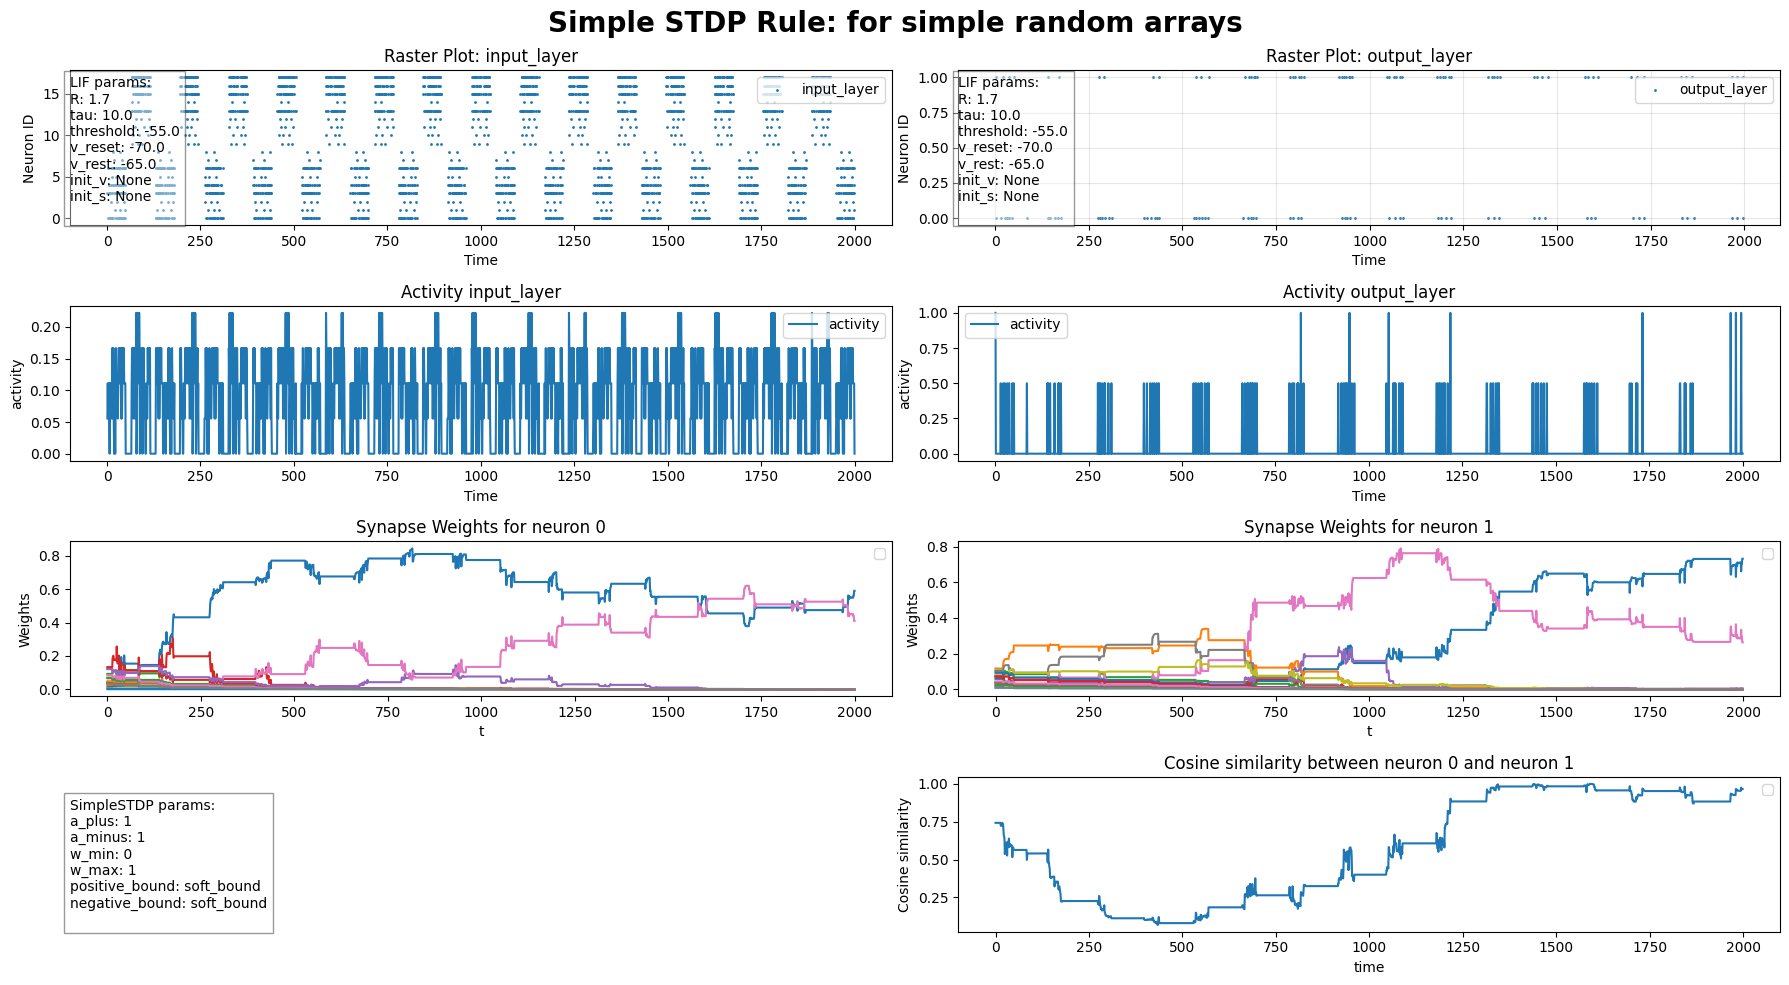

In [5]:
fig = plt.figure(figsize=(18, 10))

# ng1.add_neuron_model_params_info(ax1, model_idx=7)

ax1 = fig.add_subplot(4, 2, 1)  # 3 rows, 1 column, first plot
input_layer.add_raster_plot(ax1, event_recorder_class=EventRecorder ,s=1)
input_layer.add_neuron_model_params_info(ax1, model_behavior_class=LIF)

ax2 = fig.add_subplot(4, 2, 2)  # 3 rows, 1 column, first plot
ax2.grid(True, alpha=0.3)
output_layer.add_raster_plot(ax2, EventRecorder, s=1)
output_layer.add_neuron_model_params_info(ax2, model_behavior_class=LIF)

ax3 = fig.add_subplot(4, 2, 3, sharex=ax1)  # 3 rows, 1 column, first plot
input_layer.add_activity_plot(ax3, recorder_behavior_class=Recorder)


ax4 = fig.add_subplot(4, 2, 4, sharex=ax1)  # 3 rows, 1 column, first plot
output_layer.add_activity_plot(ax4,recorder_behavior_class=Recorder)

ax5 = fig.add_subplot(4, 2, 5)
syn_inp_out.add_weights_plot(ax5,recorder_behavior_class=Recorder, neuron_id=0)
# ng_out.add_membrane_potential_plot(ax5, model_idx=6)

ax6 = fig.add_subplot(4, 2, 6)
syn_inp_out.add_weights_plot(ax6, recorder_behavior_class=Recorder, neuron_id=1)

ax7 = fig.add_subplot(4, 2, 7)
ax7.axis("off")
syn_inp_out.add_learning_params_info(ax7, learning_behavior_class=SimpleSTDP)
# syn_inp_out.add_synapses_params_info(ax7, synapse_behavior_class=WeightInitializer, text_x=0.22, text_y=0.49)

ax8 = fig.add_subplot(4, 2, 8)
syn_inp_out.add_cosine_similarity_plot(ax8,recorder_behavior_class=Recorder, neuron_1=0, neuron_2=1)

fig.suptitle("Simple STDP Rule: for simple random arrays", fontsize=20, fontweight='bold')
plt.tight_layout()
# plt.savefig("report/plots/part2-large-array-stdp.pdf")
plt.show()

## Paired-base STDP: Local variable

In [6]:
sim = Simulation(net=Neocortex(dt=1))
input_layer = sim.add_neuron_group(
    tag="input_layer",
    # size=NeuronDimension(depth=1, height=1, width=18),
    size=18,
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            SpikeTrace(tau_s=4),
            NeuronAxon(),
        ]
    ),
)
input_layer.add_behavior(key=261,behavior=FeedDataset(encoded_dataset=encoded_dataset,sleep=15))
input_layer.add_behavior(key=350, behavior=ActivityRecorder())
input_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="input_layer_event"))
input_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="input_layer_rec"))

output_layer = sim.add_neuron_group(
    tag='output_layer',
    # size=NeuronDimension(depth=1, height=1, width=2),
    size=2,
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            Fire(),
            SpikeTrace(tau_s=3),
            NeuronAxon(),
            ActivityBaseHomeostasis(activity_rate=1,
                                    window_size=INSTANCE_DURATION + SLEEP,
                                    updating_rate=1,
                                    ),

        ]
    ),
)
output_layer.add_behavior(key=350, behavior=ActivityRecorder())
output_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="output_layer_event"))
output_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="output_layer_rec"))

syn_inp_out = sim.add_synapse_group(src=input_layer,
    dst=output_layer,
    tag="Proximal",
    behavior=prioritize_behaviors(
        [
            SynapseInit(),
            WeightInitializer(mode='random'),
            SimpleDendriticInput(current_coef=5.0),
        ]
    ),
)
syn_inp_out.add_behavior(key=400,
                         behavior=PairedSTDPLocalVar(
                                    w_max=10,
                                    w_min=-10,
                                    learning_rate=0.001
                                    )
                         )
syn_inp_out.add_behavior(key=401,
                         behavior=ClearSpikeTrace())
syn_inp_out.add_behavior(key=450, behavior=Recorder(variables=["I","weights"], tag="syn_inp_out_rec"))


sim.initialize()
sim.simulate_iterations(iterations=2000)

Network['Neocortex'](Neurons: tensor(20)|2 groups, Synapses: tensor(36)|1 groups){1:TimeResolution(dt=1,)}
NeuronGroup['input_layer', 'CustomNeuronGroup', 'ng'](18){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,)240:SimpleDendriteComputation(I_tau=None,apical_provocativeness=None,distal_provocativeness=None,)260:LIF(R=1.7,tau=10.0,threshold=-55.0,v_reset=-70.0,v_rest=-65.0,init_v=None,init_s=None,)261:FeedDataset(encoded_dataset=tensor([[[False, False, False,  ..., False, False, False],
         [ True, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False,  True, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ...,  True, False, False],
         [False, False, False,  

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


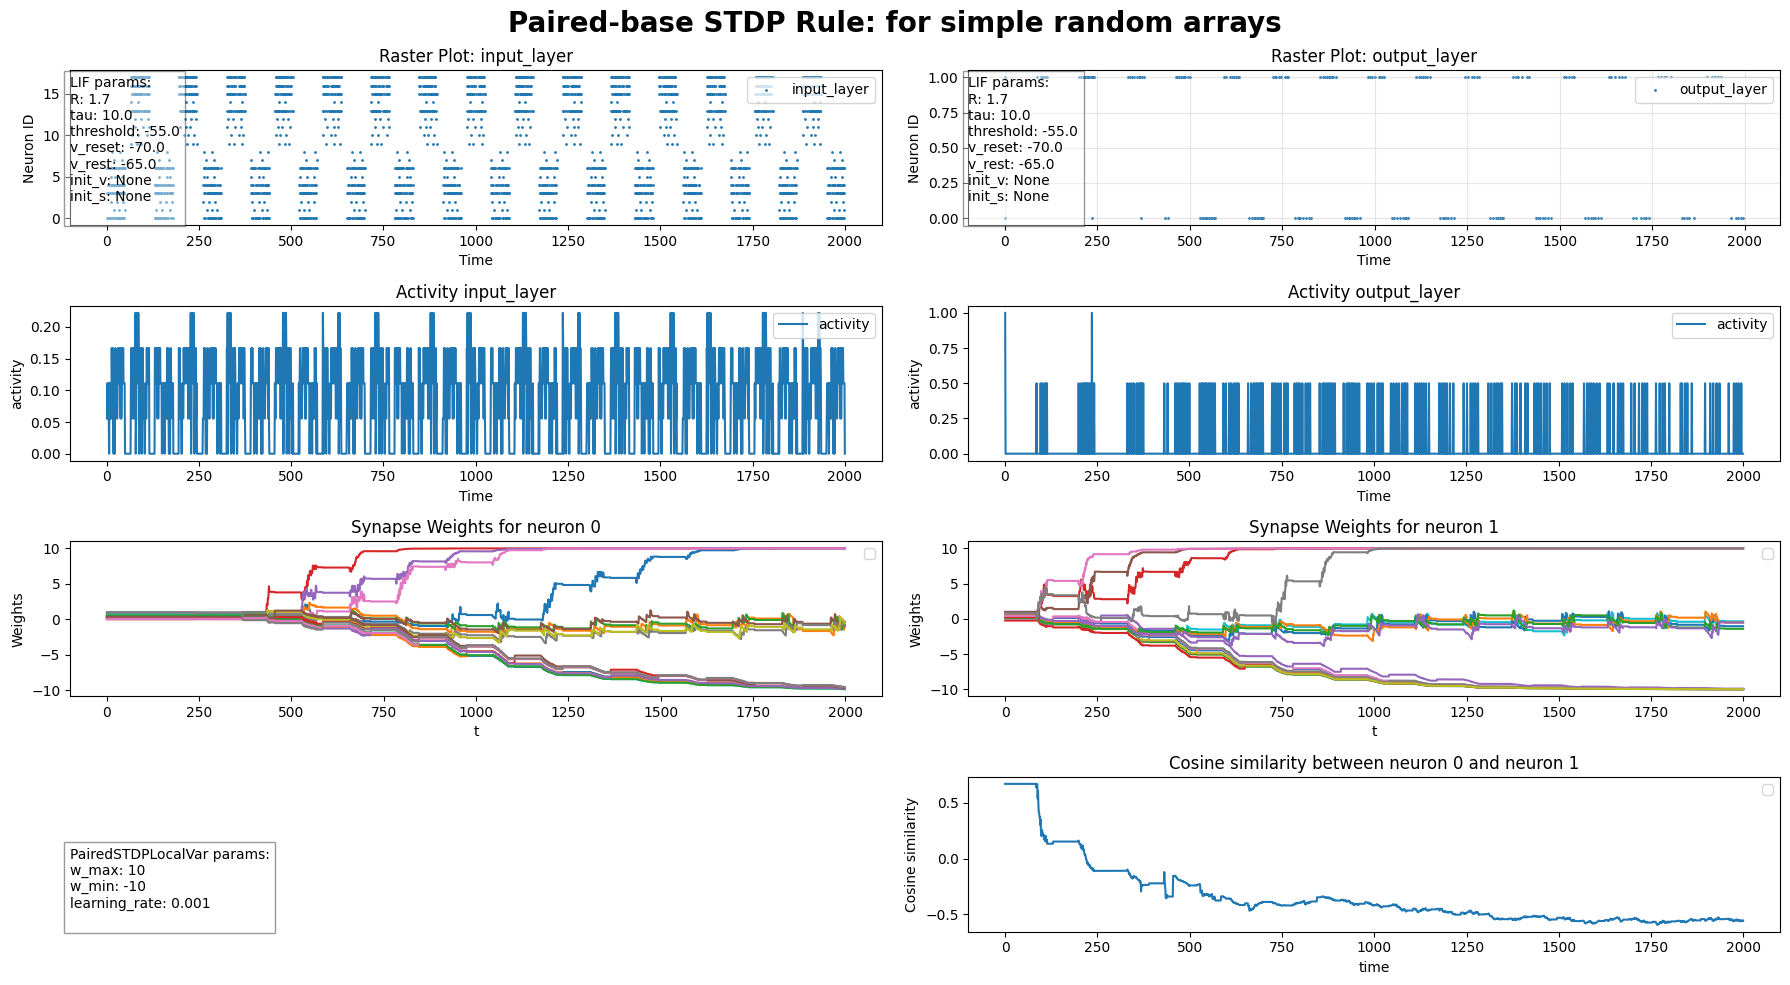

In [7]:
fig = plt.figure(figsize=(18, 10))

# ng1.add_neuron_model_params_info(ax1, model_idx=7)

ax1 = fig.add_subplot(4, 2, 1)  # 3 rows, 1 column, first plot
input_layer.add_raster_plot(ax1, event_recorder_class=EventRecorder ,s=1)
input_layer.add_neuron_model_params_info(ax1, model_behavior_class=LIF)

ax2 = fig.add_subplot(4, 2, 2)  # 3 rows, 1 column, first plot
ax2.grid(True, alpha=0.3)
output_layer.add_raster_plot(ax2, EventRecorder, s=1)
output_layer.add_neuron_model_params_info(ax2, model_behavior_class=LIF)

ax3 = fig.add_subplot(4, 2, 3, sharex=ax1)  # 3 rows, 1 column, first plot
input_layer.add_activity_plot(ax3, recorder_behavior_class=Recorder)


ax4 = fig.add_subplot(4, 2, 4, sharex=ax1)  # 3 rows, 1 column, first plot
output_layer.add_activity_plot(ax4,recorder_behavior_class=Recorder)

ax5 = fig.add_subplot(4, 2, 5)
syn_inp_out.add_weights_plot(ax5,recorder_behavior_class=Recorder, neuron_id=0)
# ng_out.add_membrane_potential_plot(ax5, model_idx=6)

ax6 = fig.add_subplot(4, 2, 6)
syn_inp_out.add_weights_plot(ax6, recorder_behavior_class=Recorder, neuron_id=1)

ax7 = fig.add_subplot(4, 2, 7)
ax7.axis("off")
syn_inp_out.add_learning_params_info(ax7, learning_behavior_class=PairedSTDPLocalVar)
# syn_inp_out.add_synapses_params_info(ax7, synapse_behavior_class=WeightInitializer, text_x=0.22, text_y=0.49)

ax8 = fig.add_subplot(4, 2, 8)
syn_inp_out.add_cosine_similarity_plot(ax8,recorder_behavior_class=Recorder, neuron_1=0, neuron_2=1)

fig.suptitle("Paired-base STDP Rule: for simple random arrays", fontsize=20, fontweight='bold')
plt.tight_layout()
# plt.savefig("report/plots/part2-large-array-stdp.pdf")
plt.show()

## Paired-base RSTDP: Local variable

In [8]:
sim = Simulation(net=Neocortex(dt=1))
input_layer = sim.add_neuron_group(
    tag="input_layer",
    size=18,
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            SpikeTrace(tau_s=4),
            NeuronAxon(),
        ]
    ),
)
input_layer.add_behavior(key=261,behavior=FeedDataset(encoded_dataset=encoded_dataset,sleep=15))
input_layer.add_behavior(key=350, behavior=ActivityRecorder())
input_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="input_layer_event"))
input_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="input_layer_rec"))

output_layer = sim.add_neuron_group(
    tag='output_layer',
    size=2,
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            Fire(),
            SpikeTrace(tau_s=3),
            NeuronAxon(),
            ActivityBaseHomeostasis(activity_rate=1,
                                    window_size=INSTANCE_DURATION + SLEEP,
                                    updating_rate=1,
                                    ),
        ]
    ),
)
output_layer.add_behavior(key=350, behavior=ActivityRecorder())
output_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="output_layer_event"))
output_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="output_layer_rec"))

syn_inp_out = sim.add_synapse_group(src=input_layer,
    dst=output_layer,
    tag="Proximal",
    behavior=prioritize_behaviors(
        [
            SynapseInit(),
            WeightInitializer(mode='random'),
            SimpleDendriticInput(current_coef=10.0),
        ]
    ),
)
syn_inp_out.add_behavior(key=400,
                         behavior=PairedRSTDPLocalVar(
                                    tau_c=50,
                                    w_max=10,
                                    w_min=-10,
                                    learning_rate=0.001,
                                    positive_dopamine=10,
                                    negative_dopamine=-10)
                         )
syn_inp_out.add_behavior(key=401,
                         behavior=ClearSpikeTrace())
syn_inp_out.add_behavior(key=450, behavior=Recorder(variables=["weights"], tag="syn_inp_out_rec"))


sim.initialize()
sim.simulate_iterations(iterations=2000)


Network['Neocortex'](Neurons: tensor(20)|2 groups, Synapses: tensor(36)|1 groups){1:TimeResolution(dt=1,)}
NeuronGroup['input_layer', 'CustomNeuronGroup', 'ng'](18){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,)240:SimpleDendriteComputation(I_tau=None,apical_provocativeness=None,distal_provocativeness=None,)260:LIF(R=1.7,tau=10.0,threshold=-55.0,v_reset=-70.0,v_rest=-65.0,init_v=None,init_s=None,)261:FeedDataset(encoded_dataset=tensor([[[False, False, False,  ..., False, False, False],
         [ True, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False,  True, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ...,  True, False, False],
         [False, False, False,  

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


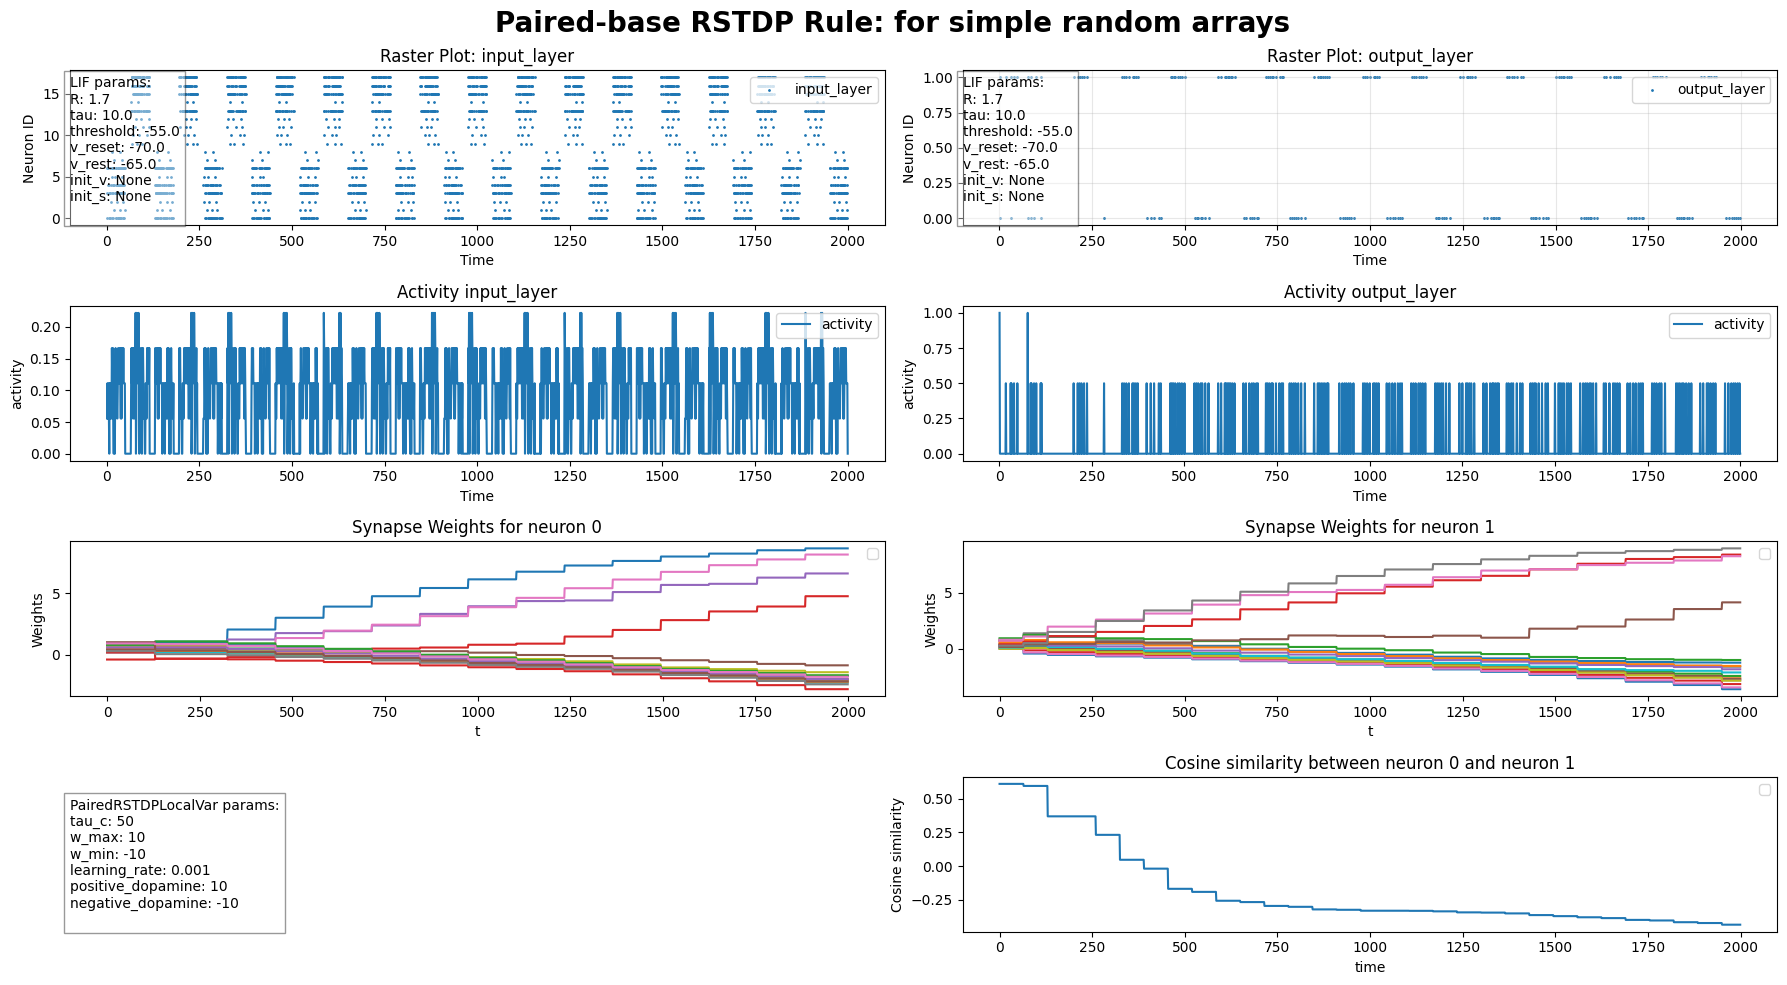

In [9]:
fig = plt.figure(figsize=(18, 10))

# ng1.add_neuron_model_params_info(ax1, model_idx=7)

ax1 = fig.add_subplot(4, 2, 1)  # 3 rows, 1 column, first plot
input_layer.add_raster_plot(ax1, event_recorder_class=EventRecorder ,s=1)
input_layer.add_neuron_model_params_info(ax1, model_behavior_class=LIF)

ax2 = fig.add_subplot(4, 2, 2)  # 3 rows, 1 column, first plot
ax2.grid(True, alpha=0.3)
output_layer.add_raster_plot(ax2, EventRecorder, s=1)
output_layer.add_neuron_model_params_info(ax2, model_behavior_class=LIF)

ax3 = fig.add_subplot(4, 2, 3, sharex=ax1)  # 3 rows, 1 column, first plot
input_layer.add_activity_plot(ax3, recorder_behavior_class=Recorder)


ax4 = fig.add_subplot(4, 2, 4, sharex=ax1)  # 3 rows, 1 column, first plot
output_layer.add_activity_plot(ax4,recorder_behavior_class=Recorder)

ax5 = fig.add_subplot(4, 2, 5)
syn_inp_out.add_weights_plot(ax5,recorder_behavior_class=Recorder, neuron_id=0)
# ng_out.add_membrane_potential_plot(ax5, model_idx=6)

ax6 = fig.add_subplot(4, 2, 6)
syn_inp_out.add_weights_plot(ax6, recorder_behavior_class=Recorder, neuron_id=1)

ax7 = fig.add_subplot(4, 2, 7)
ax7.axis("off")
syn_inp_out.add_learning_params_info(ax7, learning_behavior_class=PairedRSTDPLocalVar)
# syn_inp_out.add_synapses_params_info(ax7, synapse_behavior_class=WeightInitializer, text_x=0.22, text_y=0.49)

ax8 = fig.add_subplot(4, 2, 8)
syn_inp_out.add_cosine_similarity_plot(ax8,recorder_behavior_class=Recorder, neuron_1=0, neuron_2=1)

fig.suptitle("Paired-base RSTDP Rule: for simple random arrays", fontsize=20, fontweight='bold')
plt.tight_layout()
# plt.savefig("report/plots/part2-large-array-stdp.pdf")
plt.show()

# VoltageBaseHomeostasis

## Simple STDP

In [10]:
dataset = load_data(directory='dataset/', resize_width=3, resize_height=3)
dataset = add_overlap(dataset, overlap_ratio=0.25, epsilon=0.0)
# Create an instance of Poisson
encoder = Poisson(time_window=INSTANCE_DURATION, ratio=0.5)
# encoder = CustomPoisson(time_window=50)
encoded_dataset = torch.stack([encoder(image) for image in dataset])

In [11]:
sim = Simulation(net=Neocortex(dt=1))
input_layer = sim.add_neuron_group(
    tag="input_layer",
    # size=NeuronDimension(depth=1, height=1, width=18),
    size=18,
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            SpikeTrace(tau_s=4),
            NeuronAxon(),
        ]
    ),
)
input_layer.add_behavior(key=261,behavior=FeedDataset(encoded_dataset=encoded_dataset, sleep=SLEEP))
input_layer.add_behavior(key=350, behavior=ActivityRecorder())
input_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="input_layer_event"))
input_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="input_layer_rec"))

output_layer = sim.add_neuron_group(
    tag='output_layer',
    # size=NeuronDimension(depth=1, height=1, width=2),
    size=2,
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            Fire(),
            SpikeTrace(tau_s=3),
            NeuronAxon(),
            VoltageBaseHomeostasis(target_voltage=-60,
                                   max_ta=30,
                                   min_ta=-100,
                                    ),
        ]
    ),
)
output_layer.add_behavior(key=350, behavior=ActivityRecorder())
output_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="output_layer_event"))
output_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="output_layer_rec"))

syn_inp_out = sim.add_synapse_group(src=input_layer,
    dst=output_layer,
    tag="Proximal",
    behavior=prioritize_behaviors(
        [
            SynapseInit(),
            WeightInitializer(mode='random'),
            SimpleDendriticInput(current_coef=95.0),
            WeightNormalization(),
        ]
    ),
)
syn_inp_out.add_behavior(key=400,
                         behavior=SimpleSTDP(
                                        w_max=1,
                                        w_min=0,
                                        a_minus=1,
                                        a_plus=1,
                                         positive_bound='soft_bound',
                                         negative_bound='soft_bound')
                         )
syn_inp_out.add_behavior(key=401,
                         behavior=ClearSpikeTrace())
syn_inp_out.add_behavior(key=450, behavior=Recorder(variables=["I","weights"], tag="syn_inp_out_rec"))


sim.initialize()
sim.simulate_iterations(iterations=2000)

Network['Neocortex'](Neurons: tensor(20)|2 groups, Synapses: tensor(36)|1 groups){1:TimeResolution(dt=1,)}
NeuronGroup['input_layer', 'CustomNeuronGroup', 'ng'](18){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,)240:SimpleDendriteComputation(I_tau=None,apical_provocativeness=None,distal_provocativeness=None,)260:LIF(R=1.7,tau=10.0,threshold=-55.0,v_reset=-70.0,v_rest=-65.0,init_v=None,init_s=None,)261:FeedDataset(encoded_dataset=tensor([[[False, False, False,  ..., False, False, False],
         [ True, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [ True, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False,  True],
         [False, False, False,  

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


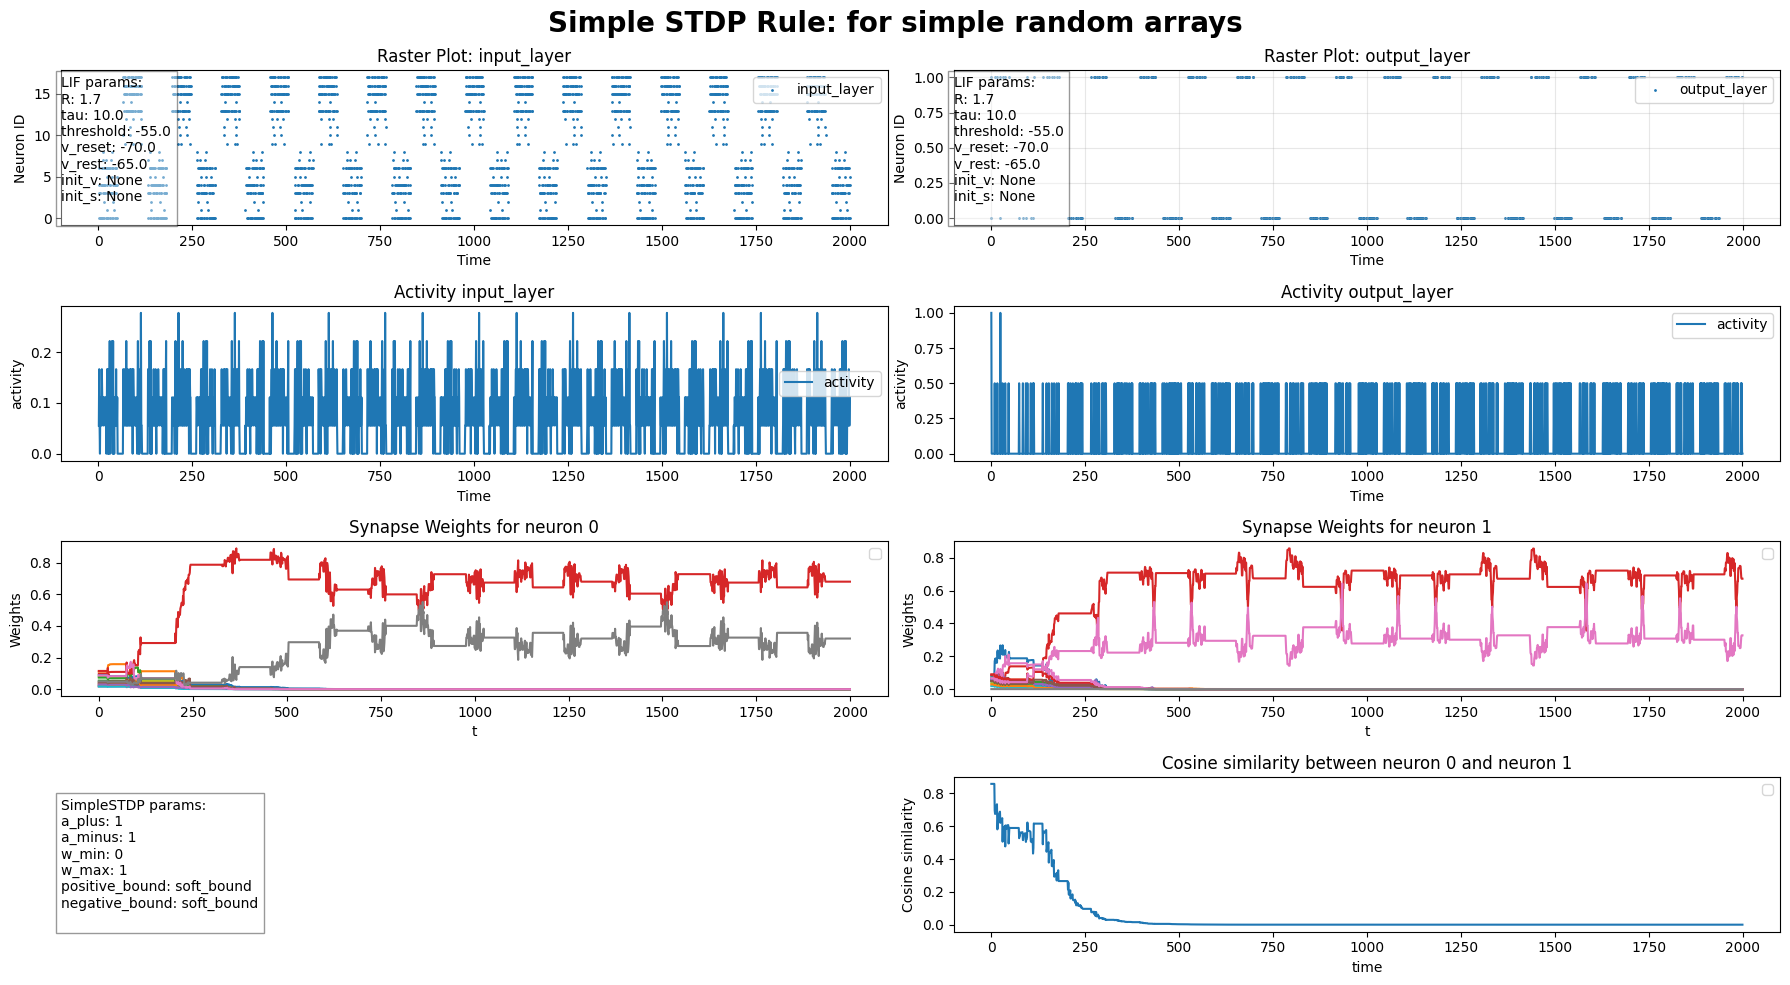

In [12]:
fig = plt.figure(figsize=(18, 10))

# ng1.add_neuron_model_params_info(ax1, model_idx=7)

ax1 = fig.add_subplot(4, 2, 1)  # 3 rows, 1 column, first plot
input_layer.add_raster_plot(ax1, event_recorder_class=EventRecorder ,s=1)
input_layer.add_neuron_model_params_info(ax1, model_behavior_class=LIF)

ax2 = fig.add_subplot(4, 2, 2)  # 3 rows, 1 column, first plot
ax2.grid(True, alpha=0.3)
output_layer.add_raster_plot(ax2, EventRecorder, s=1)
output_layer.add_neuron_model_params_info(ax2, model_behavior_class=LIF)

ax3 = fig.add_subplot(4, 2, 3, sharex=ax1)  # 3 rows, 1 column, first plot
input_layer.add_activity_plot(ax3, recorder_behavior_class=Recorder)


ax4 = fig.add_subplot(4, 2, 4, sharex=ax1)  # 3 rows, 1 column, first plot
output_layer.add_activity_plot(ax4,recorder_behavior_class=Recorder)

ax5 = fig.add_subplot(4, 2, 5)
syn_inp_out.add_weights_plot(ax5,recorder_behavior_class=Recorder, neuron_id=0)
# ng_out.add_membrane_potential_plot(ax5, model_idx=6)

ax6 = fig.add_subplot(4, 2, 6)
syn_inp_out.add_weights_plot(ax6, recorder_behavior_class=Recorder, neuron_id=1)

ax7 = fig.add_subplot(4, 2, 7)
ax7.axis("off")
syn_inp_out.add_learning_params_info(ax7, learning_behavior_class=SimpleSTDP)
# syn_inp_out.add_synapses_params_info(ax7, synapse_behavior_class=WeightInitializer, text_x=0.22, text_y=0.49)

ax8 = fig.add_subplot(4, 2, 8)
syn_inp_out.add_cosine_similarity_plot(ax8,recorder_behavior_class=Recorder, neuron_1=0, neuron_2=1)

fig.suptitle("Simple STDP Rule: for simple random arrays", fontsize=20, fontweight='bold')
plt.tight_layout()
# plt.savefig("report/plots/part2-large-array-stdp.pdf")
plt.show()

## Paired-base STDP: Local variable

In [23]:
sim = Simulation(net=Neocortex(dt=1))
input_layer = sim.add_neuron_group(
    tag="input_layer",
    # size=NeuronDimension(depth=1, height=1, width=18),
    size=18,
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            SpikeTrace(tau_s=4),
            NeuronAxon(),
        ]
    ),
)
input_layer.add_behavior(key=261,behavior=FeedDataset(encoded_dataset=encoded_dataset,sleep=15))
input_layer.add_behavior(key=350, behavior=ActivityRecorder())
input_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="input_layer_event"))
input_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="input_layer_rec"))

output_layer = sim.add_neuron_group(
    tag='output_layer',
    # size=NeuronDimension(depth=1, height=1, width=2),
    size=2,
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            Fire(),
            SpikeTrace(tau_s=3),
            NeuronAxon(),
            VoltageBaseHomeostasis(target_voltage=-60,
                                   max_ta=30,
                                   min_ta=-100,
                                    ),

        ]
    ),
)
output_layer.add_behavior(key=350, behavior=ActivityRecorder())
output_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="output_layer_event"))
output_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="output_layer_rec"))

syn_inp_out = sim.add_synapse_group(src=input_layer,
    dst=output_layer,
    tag="Proximal",
    behavior=prioritize_behaviors(
        [
            SynapseInit(),
            WeightInitializer(mode='random'),
            SimpleDendriticInput(current_coef=9.0),
        ]
    ),
)
syn_inp_out.add_behavior(key=400,
                         behavior=PairedSTDPLocalVar(
                                    w_max=10,
                                    w_min=-10,
                                    learning_rate=0.001
                                    )
                         )
syn_inp_out.add_behavior(key=401,
                         behavior=ClearSpikeTrace())
syn_inp_out.add_behavior(key=450, behavior=Recorder(variables=["I","weights"], tag="syn_inp_out_rec"))


sim.initialize()
sim.simulate_iterations(iterations=2000)

Network['Neocortex'](Neurons: tensor(20)|2 groups, Synapses: tensor(36)|1 groups){1:TimeResolution(dt=1,)}
NeuronGroup['input_layer', 'CustomNeuronGroup', 'ng'](18){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,)240:SimpleDendriteComputation(I_tau=None,apical_provocativeness=None,distal_provocativeness=None,)260:LIF(R=1.7,tau=10.0,threshold=-55.0,v_reset=-70.0,v_rest=-65.0,init_v=None,init_s=None,)261:FeedDataset(encoded_dataset=tensor([[[False, False, False,  ..., False, False, False],
         [ True, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [ True, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False,  True],
         [False, False, False,  

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


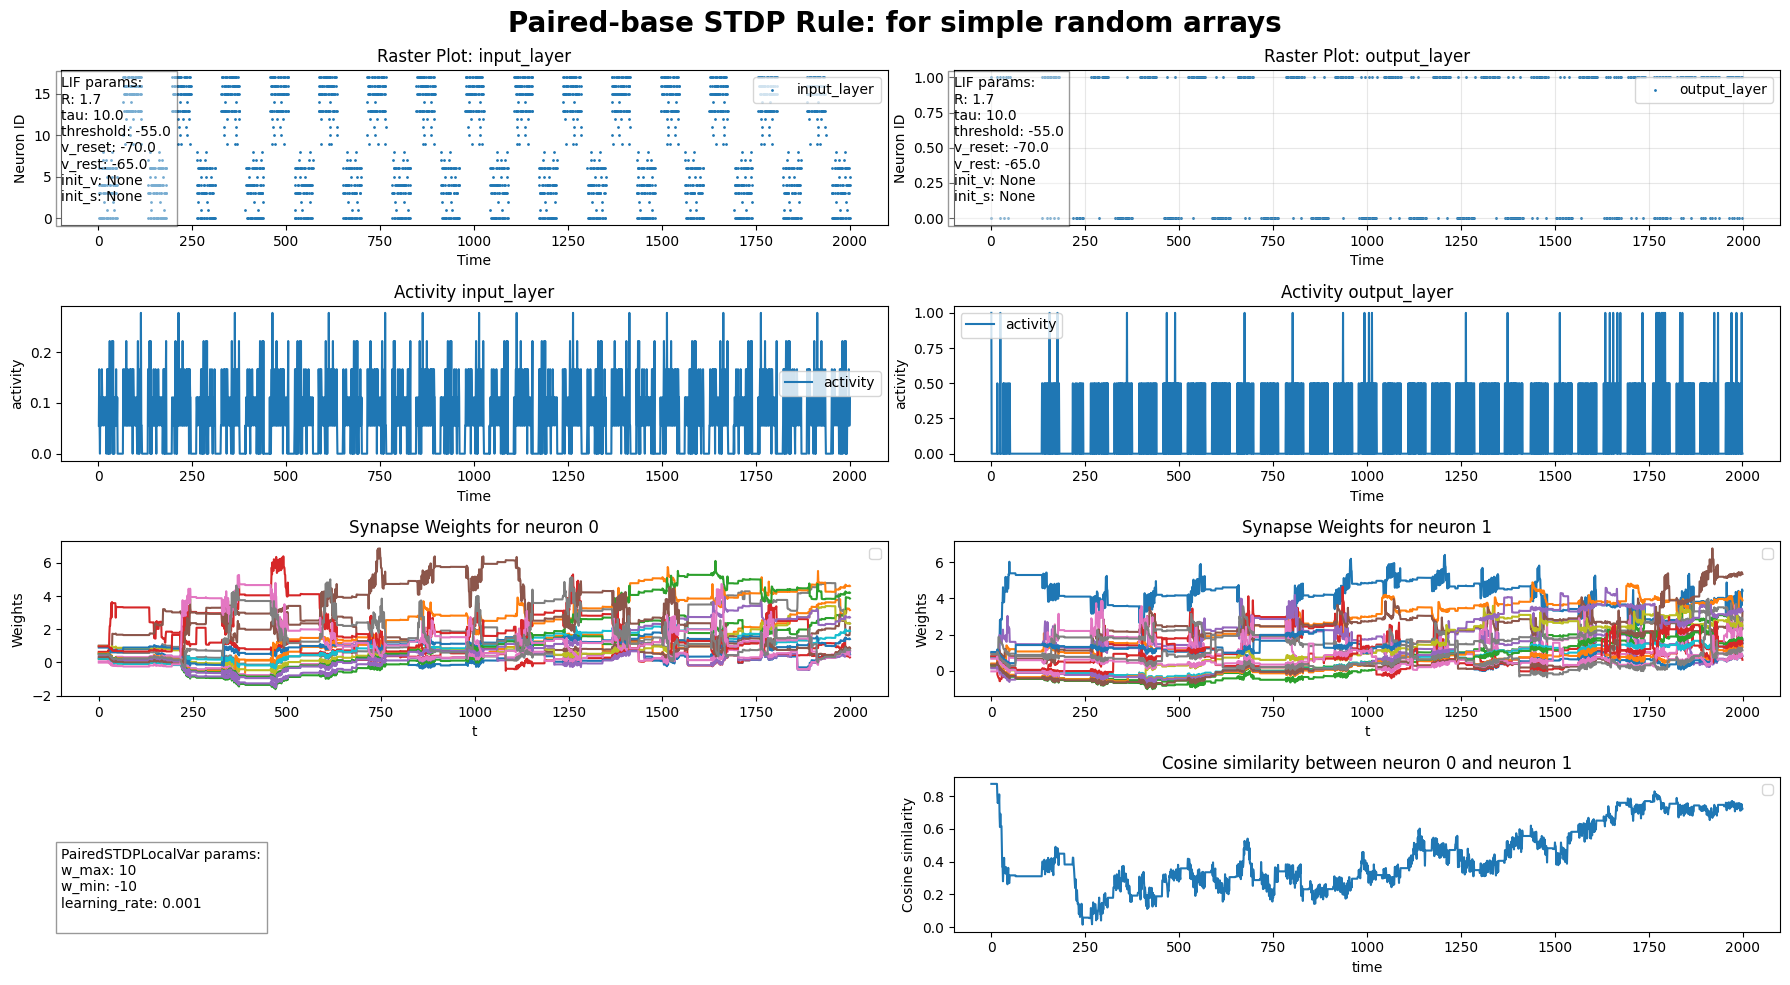

In [24]:
fig = plt.figure(figsize=(18, 10))

# ng1.add_neuron_model_params_info(ax1, model_idx=7)

ax1 = fig.add_subplot(4, 2, 1)  # 3 rows, 1 column, first plot
input_layer.add_raster_plot(ax1, event_recorder_class=EventRecorder ,s=1)
input_layer.add_neuron_model_params_info(ax1, model_behavior_class=LIF)

ax2 = fig.add_subplot(4, 2, 2)  # 3 rows, 1 column, first plot
ax2.grid(True, alpha=0.3)
output_layer.add_raster_plot(ax2, EventRecorder, s=1)
output_layer.add_neuron_model_params_info(ax2, model_behavior_class=LIF)

ax3 = fig.add_subplot(4, 2, 3, sharex=ax1)  # 3 rows, 1 column, first plot
input_layer.add_activity_plot(ax3, recorder_behavior_class=Recorder)


ax4 = fig.add_subplot(4, 2, 4, sharex=ax1)  # 3 rows, 1 column, first plot
output_layer.add_activity_plot(ax4,recorder_behavior_class=Recorder)

ax5 = fig.add_subplot(4, 2, 5)
syn_inp_out.add_weights_plot(ax5,recorder_behavior_class=Recorder, neuron_id=0)
# ng_out.add_membrane_potential_plot(ax5, model_idx=6)

ax6 = fig.add_subplot(4, 2, 6)
syn_inp_out.add_weights_plot(ax6, recorder_behavior_class=Recorder, neuron_id=1)

ax7 = fig.add_subplot(4, 2, 7)
ax7.axis("off")
syn_inp_out.add_learning_params_info(ax7, learning_behavior_class=PairedSTDPLocalVar)
# syn_inp_out.add_synapses_params_info(ax7, synapse_behavior_class=WeightInitializer, text_x=0.22, text_y=0.49)

ax8 = fig.add_subplot(4, 2, 8)
syn_inp_out.add_cosine_similarity_plot(ax8,recorder_behavior_class=Recorder, neuron_1=0, neuron_2=1)

fig.suptitle("Paired-base STDP Rule: for simple random arrays", fontsize=20, fontweight='bold')
plt.tight_layout()
# plt.savefig("report/plots/part2-large-array-stdp.pdf")
plt.show()

## Paired-base RSTDP: Local variable

In [25]:
sim = Simulation(net=Neocortex(dt=1))
input_layer = sim.add_neuron_group(
    tag="input_layer",
    size=18,
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            SpikeTrace(tau_s=4),
            NeuronAxon(),
        ]
    ),
)
input_layer.add_behavior(key=261,behavior=FeedDataset(encoded_dataset=encoded_dataset,sleep=15))
input_layer.add_behavior(key=350, behavior=ActivityRecorder())
input_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="input_layer_event"))
input_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="input_layer_rec"))

output_layer = sim.add_neuron_group(
    tag='output_layer',
    size=2,
    behavior=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                tau=10.0,
                v_rest=-65.0,
                v_reset=-70.0,
                threshold=-55.0,
                R=1.7,
            ),
            Fire(),
            SpikeTrace(tau_s=3),
            NeuronAxon(),
            VoltageBaseHomeostasis(target_voltage=-60,
                                   max_ta=30,
                                   min_ta=-100,
                                    ),
        ]
    ),
)
output_layer.add_behavior(key=350, behavior=ActivityRecorder())
output_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="output_layer_event"))
output_layer.add_behavior(key=352, behavior=Recorder(variables=["v", "I", "activity"], tag="output_layer_rec"))

syn_inp_out = sim.add_synapse_group(src=input_layer,
    dst=output_layer,
    tag="Proximal",
    behavior=prioritize_behaviors(
        [
            SynapseInit(),
            WeightInitializer(mode='random'),
            SimpleDendriticInput(current_coef=10.0),
        ]
    ),
)
syn_inp_out.add_behavior(key=400,
                         behavior=PairedRSTDPLocalVar(
                                    tau_c=50,
                                    w_max=10,
                                    w_min=-10,
                                    learning_rate=0.001,
                                    positive_dopamine=10,
                                    negative_dopamine=-10)
                         )
syn_inp_out.add_behavior(key=401,
                         behavior=ClearSpikeTrace())
syn_inp_out.add_behavior(key=450, behavior=Recorder(variables=["weights"], tag="syn_inp_out_rec"))


sim.initialize()
sim.simulate_iterations(iterations=2000)


Network['Neocortex'](Neurons: tensor(20)|2 groups, Synapses: tensor(36)|1 groups){1:TimeResolution(dt=1,)}
NeuronGroup['input_layer', 'CustomNeuronGroup', 'ng'](18){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,)240:SimpleDendriteComputation(I_tau=None,apical_provocativeness=None,distal_provocativeness=None,)260:LIF(R=1.7,tau=10.0,threshold=-55.0,v_reset=-70.0,v_rest=-65.0,init_v=None,init_s=None,)261:FeedDataset(encoded_dataset=tensor([[[False, False, False,  ..., False, False, False],
         [ True, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [ True, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False,  True],
         [False, False, False,  

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


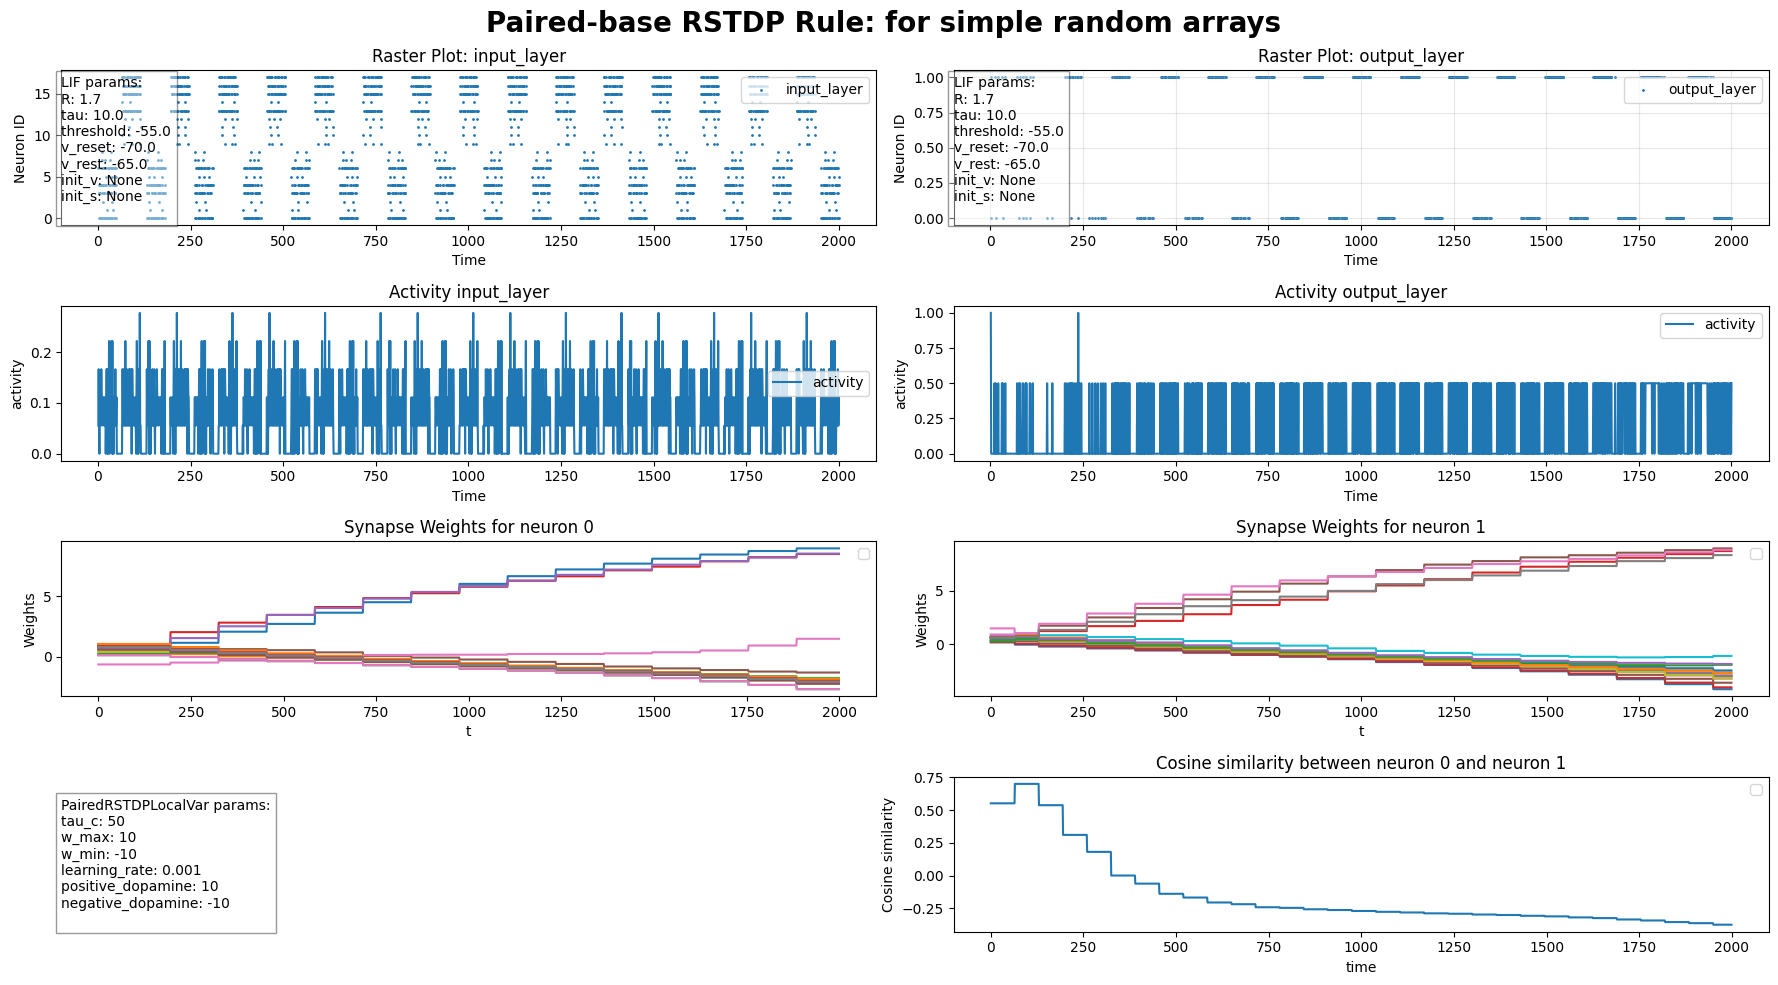

In [26]:
fig = plt.figure(figsize=(18, 10))

# ng1.add_neuron_model_params_info(ax1, model_idx=7)

ax1 = fig.add_subplot(4, 2, 1)  # 3 rows, 1 column, first plot
input_layer.add_raster_plot(ax1, event_recorder_class=EventRecorder ,s=1)
input_layer.add_neuron_model_params_info(ax1, model_behavior_class=LIF)

ax2 = fig.add_subplot(4, 2, 2)  # 3 rows, 1 column, first plot
ax2.grid(True, alpha=0.3)
output_layer.add_raster_plot(ax2, EventRecorder, s=1)
output_layer.add_neuron_model_params_info(ax2, model_behavior_class=LIF)

ax3 = fig.add_subplot(4, 2, 3, sharex=ax1)  # 3 rows, 1 column, first plot
input_layer.add_activity_plot(ax3, recorder_behavior_class=Recorder)


ax4 = fig.add_subplot(4, 2, 4, sharex=ax1)  # 3 rows, 1 column, first plot
output_layer.add_activity_plot(ax4,recorder_behavior_class=Recorder)

ax5 = fig.add_subplot(4, 2, 5)
syn_inp_out.add_weights_plot(ax5,recorder_behavior_class=Recorder, neuron_id=0)
# ng_out.add_membrane_potential_plot(ax5, model_idx=6)

ax6 = fig.add_subplot(4, 2, 6)
syn_inp_out.add_weights_plot(ax6, recorder_behavior_class=Recorder, neuron_id=1)

ax7 = fig.add_subplot(4, 2, 7)
ax7.axis("off")
syn_inp_out.add_learning_params_info(ax7, learning_behavior_class=PairedRSTDPLocalVar)
# syn_inp_out.add_synapses_params_info(ax7, synapse_behavior_class=WeightInitializer, text_x=0.22, text_y=0.49)

ax8 = fig.add_subplot(4, 2, 8)
syn_inp_out.add_cosine_similarity_plot(ax8,recorder_behavior_class=Recorder, neuron_1=0, neuron_2=1)

fig.suptitle("Paired-base RSTDP Rule: for simple random arrays", fontsize=20, fontweight='bold')
plt.tight_layout()
# plt.savefig("report/plots/part2-large-array-stdp.pdf")
plt.show()